<a href="https://colab.research.google.com/github/Mainakdeb/Wine_Quality_Prediction/blob/master/Wine_Connoisseur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn, optim
import torch.nn.functional as F
import tqdm
from tqdm import tnrange

### The Data :

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', delimiter=";")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Convert all values into float:

In [3]:
df3 = df.astype(float)

### Scale all values :

In [4]:
quality_backup = df3["quality"]
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df3), columns = df3.columns)
df_scaled['quality'] = quality_backup #restore quality values

### Balance Data :

In [5]:
max_size = df_scaled['quality'].value_counts().max()
lst = [df_scaled]
for class_index, group in df_scaled.groupby('quality'):
    lst.append(group.sample(max_size-len(group), replace=True))
frame_new = pd.concat(lst)
df_scaled2=frame_new
df_scaled2["quality"].value_counts()

6.0    2198
5.0    2198
7.0    2198
8.0    2198
4.0    2198
3.0    2198
9.0    2198
Name: quality, dtype: int64

### Shuffle Data :

In [6]:
df_scaled3=df_scaled2.sample(frac=1)

### Split into train, test and val set :

In [7]:
train = df_scaled3.iloc[:3686]
val = df_scaled3.iloc[3686:3886]
test = df_scaled3.iloc[3886:]

### Split features and labels :

In [8]:
X_train, y_train= train.drop('quality', axis=1), train['quality']
print(X_train.shape)

X_val, y_val = val.drop('quality', axis=1), val['quality']
print(X_val.shape)

X_test, y_test = test.drop("quality", axis=1), test["quality"]

(3686, 11)
(200, 11)


### Split into batches :

In [9]:
f=15 # no. of batches

train_batch = np.array_split(X_train, f) 
label_batch = np.array_split(y_train, f) # 50 sections/batches

val_batch = np.array_split(X_val, f)
val_label_batch = np.array_split(y_val, f)

test_batch = np.array_split(X_test,f) 
test_label_batch  = np.array_split(y_test, f)


for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)
    
for i in range(len(val_batch)):
    val_batch[i] = torch.from_numpy(val_batch[i].values).float()
for i in range(len(val_label_batch)):
    val_label_batch[i] = torch.from_numpy(val_label_batch[i].values).float().view(-1, 1)
    
    
for i in range(len(test_batch)):
    test_batch[i] = torch.from_numpy(test_batch[i].values).float()
for i in range(len(test_label_batch)):
    test_label_batch[i] = torch.from_numpy(test_label_batch[i].values).float().view(-1, 1)
    
print("Batch size:", len(train_batch[0]))


Batch size: 246


### The Model :

In [10]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(11, 22)
        self.fc2 = nn.Linear(22, 44)
        self.fc3 = nn.Linear(44, 88)
        self.fc4 = nn.Linear(88, 176)
        self.fc5 = nn.Linear(176, 88)
        self.fc6 = nn.Linear(88, 22)
        self.fc7 = nn.Linear(22, 1)
       
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))

        return x

model = Regressor()
train_losses, val_losses = [], []
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # 0.015 87
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.1, patience=15) 
total_epochs=0

### The training loop :

In [11]:
#print(model)
epochs = 100
total_epochs+=epochs

for e in tnrange(epochs):
    
    model.train()
    train_loss = 0
    val_loss_1=0
    val_loss_sum = 0
    
    for i in range(len(train_batch)):
        
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
        with torch.no_grad():
            
            for j in range(len(val_batch)):
                
                val_output = model(val_batch[j])
                val_loss =  criterion(val_output, val_label_batch[j])
                val_loss_1+=val_loss.item()
        val_loss_sum=val_loss_1/len(val_batch)
        
        
    print("Epoch :", e, "train_loss :", train_loss/len(train_batch), "Val loss: ", val_loss_sum/len(val_batch))    
    val_losses.append(val_loss_sum/len(val_batch))    
    train_losses.append(train_loss/len(train_batch))   

C:\Users\user\AppData\Local\Temp\ipykernel_14572\3936817407.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for e in tnrange(epochs):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 0 train_loss : 15.942656230926513 Val loss:  13.149350804222955
Epoch : 1 train_loss : 3.9693493366241457 Val loss:  4.348674485948351
Epoch : 2 train_loss : 3.1072428544362385 Val loss:  3.527471046977573
Epoch : 3 train_loss : 2.681070836385091 Val loss:  3.1252416303422716
Epoch : 4 train_loss : 2.5484922409057615 Val loss:  3.0170690949757892
Epoch : 5 train_loss : 2.4487693548202514 Val loss:  2.8986706235673694
Epoch : 6 train_loss : 2.368021519978841 Val loss:  2.774513603846232
Epoch : 7 train_loss : 2.294491243362427 Val loss:  2.6367565774917603
Epoch : 8 train_loss : 2.2245659510294598 Val loss:  2.5302334859636093
Epoch : 9 train_loss : 2.1780914386113484 Val loss:  2.4375566106372406
Epoch : 10 train_loss : 2.1690611600875855 Val loss:  2.4105930127037896
Epoch : 11 train_loss : 2.076566449801127 Val loss:  2.3228496215078565
Epoch : 12 train_loss : 2.0086848020553587 Val loss:  2.2674899201922947
Epoch : 13 train_loss : 1.9269458134969075 Val loss:  2.205086890061

### Training Metrics :

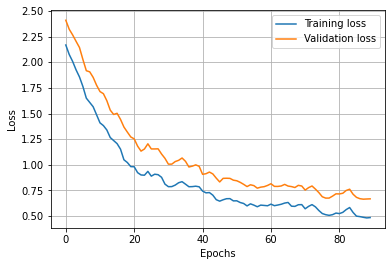

In [12]:
frm=10 # does not 
plt.plot(train_losses[frm:], label='Training loss')
plt.plot(val_losses[frm:], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

### How does the model perform on the test-set?

In [13]:
correct=0
i=0
res=[]
with torch.no_grad():
    for batch in test_batch :
        for j in range(len(batch)):
            x = model(batch[j])
            #print(round(x.item()))
            res.append(round(x.item()))

true_labels= list(test["quality"])

for i in range(len(res)):
    if res[i]==int(true_labels[i]):
        correct+=1
        
print("Accuracy:", 100*(correct/len(res)), "%")

Accuracy: 52.93043478260869 %
